## importing all the necessary libraries

In [1]:
!pip install spacy
!pip install wordcloud
!pip install gensim
import spacy
import json
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter
from collections import defaultdict
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.cm as cm
from matplotlib import rcParams
import numpy as np
from spacy.matcher import PhraseMatcher
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from heapq import nlargest
!pip install sumy
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
import nltk
import re
!python -m spacy download en_core_web_sm

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 55.4 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


### loading a spaCy language model, sets a file path, and then loads JSON data from that file

In [4]:
# Loading  the spaCy model
nlp = spacy.load("en_core_web_sm")

#  the file path
file_path = '/workspaces/LLM/training_booklet.json'

# Load JSON data
with open(file_path, 'r') as file:
    data_text = json.load(file)

### processing a text using spaCy by tokenizing it, filtering out stop words, punctuation, and whitespace, and then counting word frequency

In [5]:
# Processing  the text with spaCy
processed_text = []
for key, text in data_text.items():
    # Process the document using spaCy
    doc = nlp(text)
    
    # Tokenizing the text and filter out stop words, punctuation, and whitespace
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space]
    
    # Collecting the tokens
    processed_text.extend(tokens)
    

word_freq = Counter(processed_text)
print(word_freq.most_common(10)) 

[('child', 215), ('information', 181), ('patient', 178), ('abuse', 163), ('training', 143), ('staff', 142), ('page', 123), ('record', 111), ('need', 110), ('care', 99)]


### Generating Wordcloud

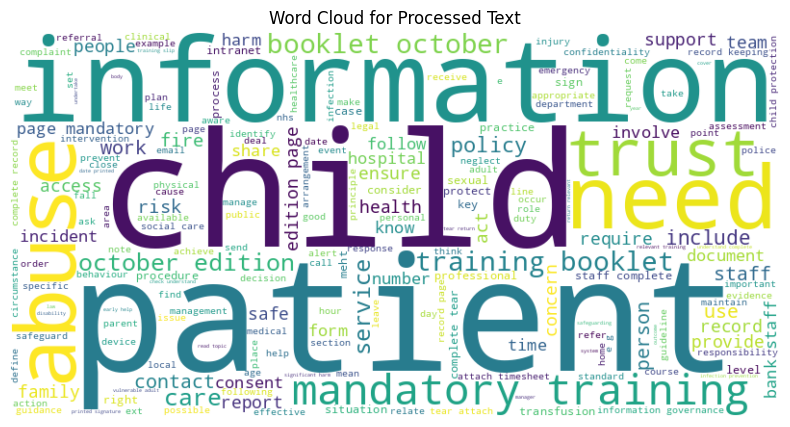

In [6]:
# Processing the text with spaCy
processed_text = []
for key, text in data_text.items():
    # Processing the document using spaCy
    doc = nlp(text)
    
    # Tokenizing the text and filter out stop words, punctuation, and whitespace
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space]
    
    # Collecting the tokens
    processed_text.extend(tokens)

# Generating a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(processed_text))

# Displaying the generated WordCloud image using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove the axis
plt.title('Word Cloud for Processed Text')
plt.show()


### creating  a horizontal bar chart of the 10 most common words in the processed text

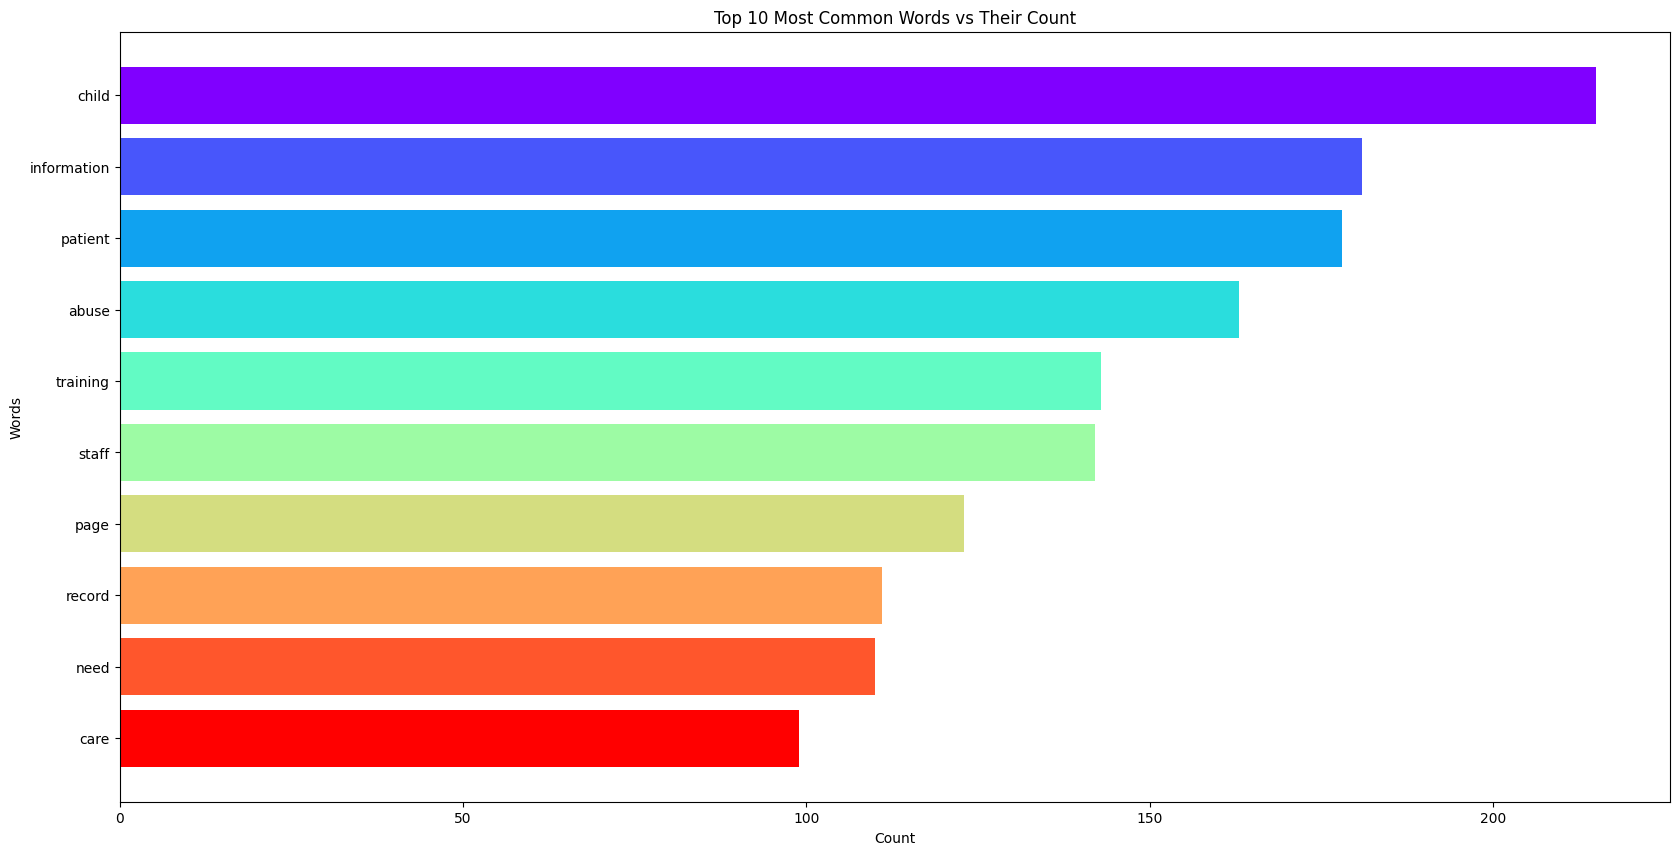

In [7]:
# Counting the words and get the most common ones
counted_words = Counter(processed_text)
words = []
counts = []
for word, count in counted_words.most_common(10):
    words.append(word)
    counts.append(count)



# Plotting the most common words as a horizontal bar chart
colors = cm.rainbow(np.linspace(0, 1, len(words)))
rcParams['figure.figsize'] = 20, 10
plt.title('Top 10 Most Common Words vs Their Count')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)
plt.gca().invert_yaxis()  
plt.show()


### Named Entity Recognition (NER)

In [8]:

# Using spaCy's NER to extract named entities, which can help in understanding the context or identifying key topics.
named_entities = []
for key, text in data_text.items():
    # Process the document using spaCy
    doc = nlp(text)
    
    # Extract entities and their labels
    entities = [(entity.text, entity.label_) for entity in doc.ents]
    named_entities.extend(entities)

# Counting  the entities and get the most common ones
entity_freq = Counter(named_entities)
common_entities = entity_freq.most_common(10)

# Displaying the top entities
print("Most common named entities:")
for entity, freq in common_entities:
    print(f"{entity[0]} ({entity[1]}): {freq}")

common_nouns = []
common_verbs = []
for key, text in data_text.items():
    # Processing the document using spaCy
    doc = nlp(text)
    
    # Extracting nouns and verbs
    nouns = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and token.pos_ == "NOUN" and token.lemma_ != '|']
    verbs = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and token.pos_ == "VERB"]
    common_nouns.extend(nouns)
    common_verbs.extend(verbs)

# Counting the nouns and verbs and get the most common ones
noun_freq = Counter(common_nouns)
verb_freq = Counter(common_verbs)
common_nouns = noun_freq.most_common(10)
common_verbs = verb_freq.most_common(10)

# Displaying the top nouns and verbs
print("Most common nouns:")
for noun, freq in common_nouns:
    print(f"{noun}: {freq}")

print("Most common verbs:")
for verb, freq in common_verbs:
    print(f"{verb}: {freq}")


Most common named entities:
October 2014 (DATE): 79
First Edition (ORG): 78
Trust (ORG): 29
2 (CARDINAL): 20
first (ORDINAL): 14
NHS (ORG): 12
MEHT (ORG): 12
3 (CARDINAL): 10
two (CARDINAL): 9
one (CARDINAL): 9
Most common nouns:
child: 211
information: 141
patient: 137
staff: 131
abuse: 127
page: 102
record: 85
care: 77
fire: 67
service: 66
Most common verbs:
need: 63
include: 61
provide: 47
complete: 47
ensure: 42
work: 38
require: 38
report: 37
safeguard: 37
follow: 36


###  using spaCy's PhraseMatcher to identify and count specific phrases in a text dataset

In [9]:
# Initialize the PhraseMatcher with the spaCy vocabulary
matcher = PhraseMatcher(nlp.vocab)

# Defining some patterns to match
phrases = ["health care", "patient experience", "clinical practice", "medical treatment"]  # Add more phrases as needed
patterns = [nlp.make_doc(text) for text in phrases]
matcher.add("HEALTH_PATTERNS", patterns)

# Finding matches in the text
matched_phrases = []
for key, text in data_text.items():
    doc = nlp(text)
    matches = matcher(doc)
    for match_id, start, end in matches:
        span = doc[start:end]  # The matched span
        matched_phrases.append(span.text)

# Count the matched phrases and get the most common ones
phrase_freq = Counter(matched_phrases)
common_phrases = phrase_freq.most_common(25)

# Displaying the top phrases
print("Most common phrases:")
for phrase, freq in common_phrases:
    print(f"{phrase}: {freq}")

Most common phrases:
health care: 3
clinical practice: 3
patient experience: 2


 ### Topic modeling on the processed_text using the LDA (Latent Dirichlet Allocation) model from the gensim library.

In [10]:
# Creating a Dictionary from the articles: dictionary of the frequency of each word.
dictionary = corpora.Dictionary([processed_text])

# Converting to list of bags of words.
corpus = [dictionary.doc2bow(text) for text in [processed_text]]

# Using LDA model to find  the topics
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=15, random_state=42)


topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)
   




(0, '0.015*"child" + 0.012*"information" + 0.012*"patient" + 0.011*"abuse" + 0.010*"training"')
(1, '0.000*"information" + 0.000*"abuse" + 0.000*"staff" + 0.000*"patient" + 0.000*"child"')
(2, '0.000*"child" + 0.000*"information" + 0.000*"abuse" + 0.000*"staff" + 0.000*"patient"')
(3, '0.000*"child" + 0.000*"training" + 0.000*"patient" + 0.000*"information" + 0.000*"abuse"')
(4, '0.000*"information" + 0.000*"patient" + 0.000*"child" + 0.000*"abuse" + 0.000*"training"')


### Creating a set of horizontal bar charts that represent the top words in each topic discovered by the LDA model, along with the probability of those words in the topics

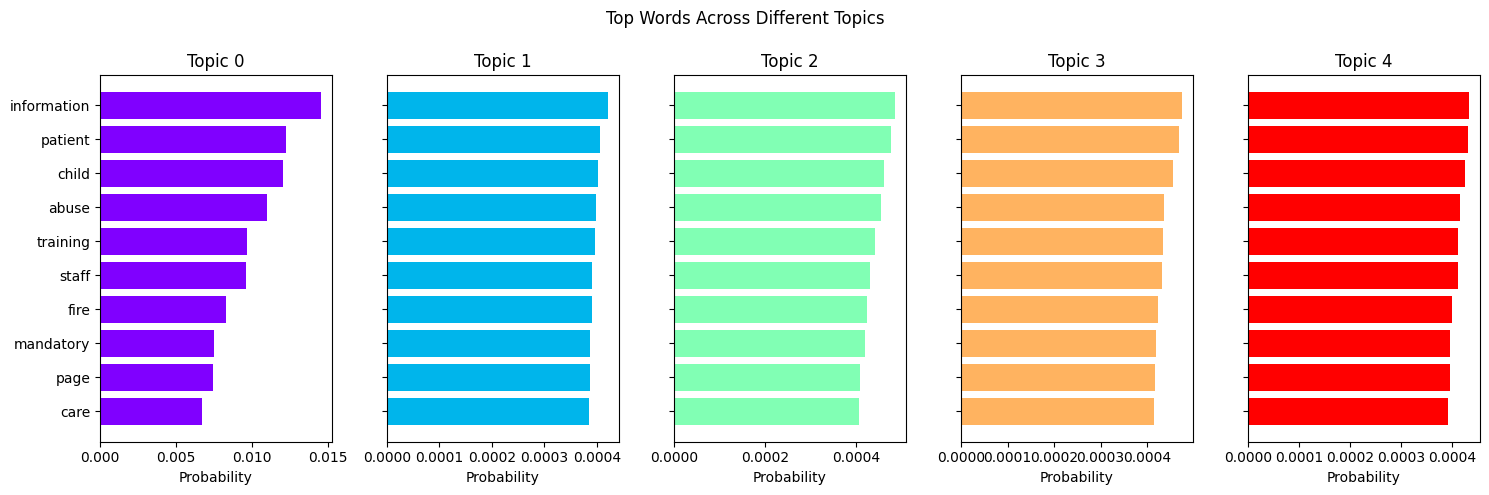

In [11]:
#Top Words Across Different Topics

n_topics = lda_model.num_topics
n_words = 10

# Retrieving words from each topic
topic_words = {i: [word for word, prob in lda_model.show_topic(i, topn=n_words)] for i in range(n_topics)}

colors = plt.cm.rainbow(np.linspace(0, 1, n_topics))

fig, axes = plt.subplots(1, n_topics, figsize=(15, 5), sharey=True)
fig.suptitle('Top Words Across Different Topics')

# Plot bars for each topic's top words
for i, ax in enumerate(axes.flatten()):
    # Retrieve the top words and their probabilities
    words, probs = zip(*[(word, prob) for word, prob in lda_model.show_topic(i, topn=n_words)])
    y_pos = np.arange(len(words))
    
   
    ax.barh(y_pos, probs, align='center', color=colors[i])
    ax.set_yticks(y_pos)
    ax.set_yticklabels(words)
    ax.invert_yaxis() 
    ax.set_xlabel('Probability')
    ax.set_title('Topic {}'.format(i))

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

### summarizing text using a simple frequency-based method

In [12]:
#Text Summarization 
combined_text = " ".join(data_text.values())  # Combining all text into one string for summarization

# Processing the combined text with spaCy
doc = nlp(combined_text)

sentence_ranks = {}
for sent in doc.sents:
    for token in sent:
        if token.lemma_ in processed_text: 
            if sent in sentence_ranks:
                sentence_ranks[sent] += 1
            else:
                sentence_ranks[sent] = 1

# Selecting the top n sentences for summary
n_sentences = 5
summary_sentences = nlargest(n_sentences, sentence_ranks, key=sentence_ranks.get)

# Combining selected sentences into one summary string
summary = ' '.join([sent.text for sent in summary_sentences])

print('Summary:')
print(summary)

Summary:
You, Your Workstation, Work Area or Desk  wear your identity badge at all times  politely challenge anyone who appears to be accessing information that you don't think they are entitled to see  lock up everything sensitive when leaving the area unmanned, don't leave sensitive information lying around on desktops  don't let anyone (particularly patients and visitors) see what is on your computer screen  don't permit patient identifiable information on whiteboards  keep your password confidential at all times and share it with no-one  log off when you are not at your desk  don't allow anyone to access networked services whilst you are logged on - you then become responsible for what they access which may be inappropriate and a breach of policy and you may be subject to disciplinary action  use a strong password - with lower case, upper case and numbers  never keep passwords adjacent to the device to which it refers eg writing the encryption password on the back of an encrypted d

### The below code is structured to perform text cleaning and summarization in several steps, leveraging regular expressions and Latent Semantic Analysis (LSA) for summarization

In [15]:
## This regex pattern is designed to match a specific section in the text that starts with "Your Mandatory Training Booklet | October 2014: First Edition"
# and continues until it reaches a point where the next sentence starts with an uppercase letter following a period, or it finds a period marking the end of the section.
# It's used here to clean the text by removing this matched section before further processing.
import nltk
nltk.download('punkt')

pattern = r"\bYour\s+Mandatory\s+Training\s+Booklet\s+\|\s+October\s+2014:\s+First\s+Edition.*?(?=\.\s+[A-Z]|\.$)"


# Removing the matched section from the combined_text to clean it for further analysis.
cleaned_text = re.sub(pattern, '', combined_text, flags=re.S)

# Parse the input text
parser = PlaintextParser.from_string(cleaned_text, Tokenizer("english"))
 
# Creating an LSA summarizer
summarizer = LsaSummarizer()
 
# Generating the summary

summary = summarizer(parser.document, sentences_count=10)
 
# Output the summary
for sentence in summary:
    print(sentence)


[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


We are aware that for some of our staff, working specific shifts, temporary patterns and family commitments may preclude undertaking training in the more traditional way.
Simple steps can be taken to ensure that you are working safely:  Use personal protective equipment (PPE) provided e.g. gloves, masks, respirators and overalls.
Be familiar with your local COSHH file  Consult safety data sheets for information about the substance  Use control measures as instructed.
These are in the form of Southend Essex & Thurrock (SET) Safeguarding Adult Guidelines using multiagency procedures to safeguard vulnerable adults from abuse.
Stay calm and try not to show shock or disbelief  Listen carefully, supporting this with appropriate non-verbal cues (nodding, open body posture, leaning forward etc.)
Within the work environment, however, caring for someone often means invading their personal space and it is important to remember that this can make them feel uncomfortable or anxious.
Portable media 